In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ssm

from src.load_data import load_data 

In [25]:
#!pip install src/ssm/ -e .

## Load Data

In [362]:
df = load_data(path='data/CSH_ZAD_019.csv')
df.columns

Index(['Unnamed: 0', 'probabilityLeft', 'feedback_times', 'contrastRight',
       'contrastLeft', 'response_times', 'feedbackType', 'stimOn_times',
       'choice', 'firstMovement_times', 'goCue_times', 'rewardVolume',
       'intervals_0', 'intervals_1', 'session', 'session_start_time',
       'session_number', 'task_protocol'],
      dtype='object')

<Axes: >

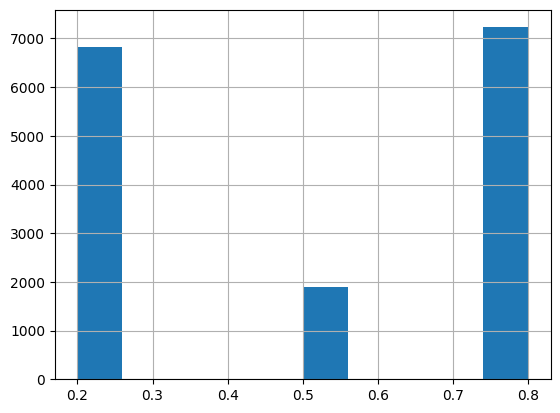

In [363]:
# Filter only July and Agust sessions (full task)
bdf7 = df[df["session_start_time"].str.contains("2020-07")]
bdf8 = df[df["session_start_time"].str.contains("2020-08")] 
bdf = pd.concat([bdf7, bdf8]).sort_index()
bdf.probabilityLeft.hist()

<Axes: >

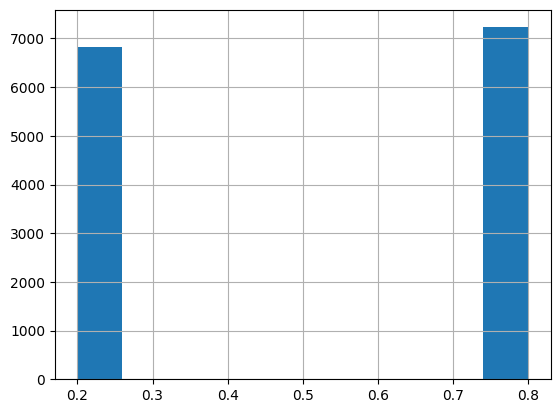

In [364]:
# Filter by probability left
cdf2 = bdf[bdf["probabilityLeft"]==0.2]
cdf8 = bdf[bdf["probabilityLeft"]==0.8]
cdf = pd.concat([cdf2, cdf8]).sort_index()
cdf.probabilityLeft.hist()

In [365]:
len(df.session.unique())
#len(bdf.session.unique())
#len(cdf.session.unique())

77

In [366]:
cdf.session_start_time.unique()

array(['2020-07-14 10:25:12.739113', '2020-08-13 10:32:23.510709',
       '2020-08-19 11:31:40.000000', '2020-08-11 09:35:28.164173',
       '2020-07-09 08:39:39.686985', '2020-08-10 15:29:27.381124',
       '2020-08-16 07:39:40.000000', '2020-08-12 10:13:28.494154',
       '2020-07-08 14:51:44.566364', '2020-08-03 08:28:23.216558',
       '2020-07-17 13:08:44.585041', '2020-07-10 14:30:37.590534',
       '2020-08-04 08:29:51.919526', '2020-07-20 11:58:08.470744',
       '2020-08-07 08:09:22.479575', '2020-07-13 12:54:36.164264',
       '2020-08-14 11:36:42.000000', '2020-07-16 12:55:04.715750',
       '2020-08-18 07:41:02.000000', '2020-07-22 12:29:23.349371',
       '2020-07-21 11:41:20.605764'], dtype=object)

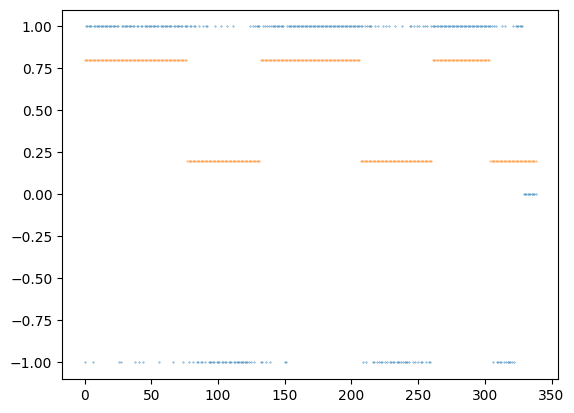

In [139]:
session_id = cdf.session.iloc[10548]
mouseN_df = cdf[cdf["session"]==session_id]
plt.scatter(np.arange(len(mouseN_df["choice"])), mouseN_df["choice"], s=0.09)
plt.scatter(np.arange(len(mouseN_df["probabilityLeft"])), mouseN_df["probabilityLeft"], s=0.09)
plt.show()

## Psychometric Curves

## GLM-HMM

In [137]:
# Set the parameters of the GLM-HMM
num_states = 2        # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2         # input dimensions

# Make a GLM-HMM
true_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

# true_hmm = ssm.HMM(num_states, obs_dim, input_dim, 
#                observations="categorical", observation_kwargs=dict(C=num_categories),
#                transitions="inputdriven")

In [141]:
gen_weights = np.array([[[6, 1]], [[2, -3]], [[2, 3]]])
gen_log_trans_mat = np.log(np.array([[[0.98, 0.01, 0.01], [0.05, 0.92, 0.03], [0.03, 0.03, 0.94]]]))
true_glmhmm.observations.params = gen_weights
true_glmhmm.transitions.params = gen_log_trans_mat

In [192]:
# External input sequences
num_sess = 20 # number of example sessions
num_trials_per_sess = 100 # number of trials in a session
inpts = np.ones((num_sess, num_trials_per_sess, input_dim)) # initialize inpts array
stim_vals = [-1, -0.5, -0.25, -0.125, -0.0625, 0, 0.0625, 0.125, 0.25, 0.5, 1]
inpts[:,:,0] = np.random.choice(stim_vals, (num_sess, num_trials_per_sess)) # generate random sequence of stimuli
inpts = list(inpts) #convert inpts to correct format

In [193]:
cdf.columns

Index(['Unnamed: 0', 'probabilityLeft', 'feedback_times', 'contrastRight',
       'contrastLeft', 'response_times', 'feedbackType', 'stimOn_times',
       'choice', 'firstMovement_times', 'goCue_times', 'rewardVolume',
       'intervals_0', 'intervals_1', 'session', 'session_start_time',
       'session_number', 'task_protocol'],
      dtype='object')

[0.125     nan 0.25   0.     0.0625 1.    ]
[   nan 0.125  0.0625 0.     0.25   1.    ]


<Axes: >

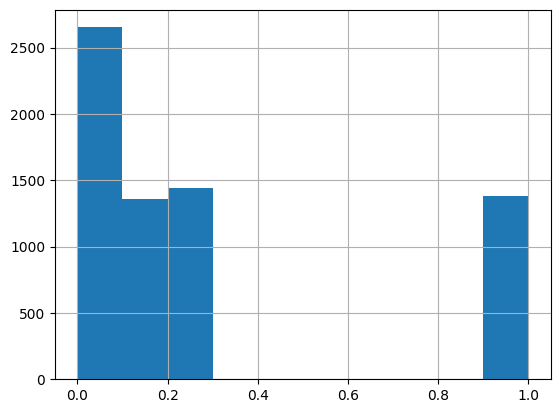

In [216]:
print(cdf.contrastRight.unique() )
print(cdf.contrastLeft.unique() )
cdf.contrastRight.hist()
#cdf[["contrastRight", "contrastLeft"]]

In [248]:
df.probabilityLeft

0        0.5
1        0.9
2        0.5
3        0.5
4        0.5
        ... 
60496    0.5
60497    0.5
60498    0.5
60499    0.5
60500    0.5
Name: probabilityLeft, Length: 60501, dtype: float64

/tmp/ipykernel_957/3886850403.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5["rewards"] = df5["rewardVolume"].replace(0.0, -1).replace(1.5, 1)


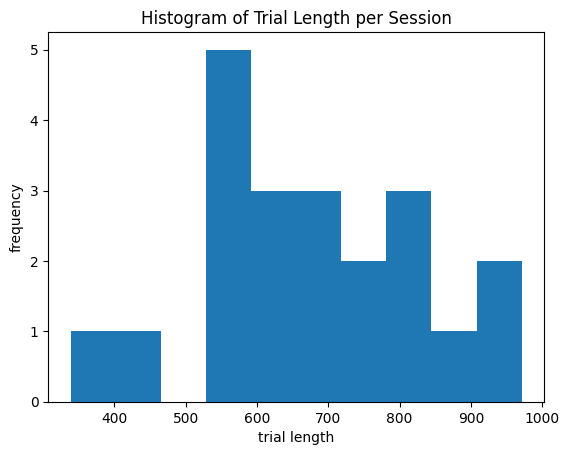

In [588]:
# Get choices as matrix
def get_trials_by_session_matrix(dt, column, trim=True, plot_untrimmed_hist=False):
    grouped = dt.groupby('session')[column]
    untrimmed_choices = [group.values for name, group in grouped]
    if trim:
        min_arr_l = min(len(arr) for arr in untrimmed_choices)
        matrix = [arr[:min_arr_l] for arr in untrimmed_choices]
        #matrix = np.array(matrix)
    else:
        matrix = untrimmed_choices
    if plot_untrimmed_hist:
        lens = []
        for i in range(len(untrimmed_choices)):
            lens.append(len(untrimmed_choices[i]))
        plt.hist(lens)
        plt.title("Histogram of Trial Length per Session")
        plt.xlabel("trial length")
        plt.ylabel("frequency")
    return matrix

choices = get_trials_by_session_matrix(cdf, "choice", plot_untrimmed_hist=True)
choices_cl = [choice.reshape(-1, 1) for choice in choices]


# Create external input sequences
inputs = []

# Create contrasts
cdf["mergedContrasts"] = cdf["contrastRight"].fillna(0) - cdf["contrastLeft"].fillna(0)
contrasts = get_trials_by_session_matrix(cdf, "mergedContrasts")

# Create Biases
biases = [np.array([1]*min_arr_l)]*len(choices)

# Create previous choice
df5 = bdf[bdf["probabilityLeft"]==0.5]
first_choices = np.array(get_trials_by_session_matrix(df5, "choice", trim=False))[:, -1]
#first_choices = [0]*len(choices)
prev_choices = []
for sess_i, session in enumerate(choices):
    prev_c = np.insert(session, 0, first_choices[sess_i]) # new first choice from 50:50
    prev_c = prev_c[:-1]
    prev_choices.append(prev_c)

# Win-stay-lose-switch
df5["rewards"] = df5["rewardVolume"].replace(0.0, -1).replace(1.5, 1)
first_rewards = np.array(get_trials_by_session_matrix(df5, "rewards", trim=False))[:, -1]
cdf["rewards"] = cdf["rewardVolume"].replace(0.0, -1).replace(1.5, 1)
rewards = get_trials_by_session_matrix(cdf, "rewards")

prev_rewards = []
ws_ls = []
for rew_i, rew in enumerate(rewards):
    prev_r = np.insert(rew, 0, first_rewards[rew_i]) # new first reward from 50:50
    prev_r = prev_r[:-1]
    prev_rewards.append(prev_r) 

    ws_ls.append(prev_r * choices[rew_i])

inpts = []
for i, choice in enumerate(choices):
    inpt = np.vstack([contrasts[i], biases[i], prev_choices[i], ws_ls[i]]).T
    inpts.append(inpt)

In [578]:
print(len(choices_cl))
print(len(choices_cl[0]))
print(len(choices_cl[0][0]))
print(len(inpts))
print(len(inpts[0]))
print(len(inpts[0][0]))


print(np.shape(choices_cl))

21
339
1
21
339
4
(21, 339, 1)


In [517]:
def switch_zeros_and_ones(choice):
    return np.array([1 if choice==1 else 0 for choice in choices_cl[0] ]).reshape(-1, 1)

choices_xx = [switch_zeros_and_ones(choice) for choice in choices_cl]

In [580]:
np.shape(choices_xx)
choices_xx

[array([[0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],

In [524]:
print(len(X_train))
print(len(X_test))

18
3


In [605]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

likelihoods = []
num_all_states = []
mean_lls_train = []
mean_lls_test = []
max_num_states = 5
 
for num_states in tqdm (range(max_num_states+1, 1, -1), desc="Loading..."):
    #num_states = 2        # number of discrete states
    obs_dim = 1           # number of observed dimensions
    num_categories = 2    # number of categories for output
    input_dim = 4         # input dimensions

    glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                    observation_kwargs=dict(C=num_categories), transitions="standard")

    train_lls = []
    test_lls = []

    k=8 #5
    kf = KFold(n_splits=k)
    print("Number of splits: ", kf.get_n_splits(inpts))
    for train_index, test_index in kf.split(inpts):
        inpts_train = [inpts[i] for i in train_index]
        inpts_test = [inpts[i] for i in test_index]
        choices_train = [choices_xx[i] for i in train_index]
        choices_test = [choices_xx[i] for i in test_index]

        N_iters = 400 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter

        fit_ll = glmhmm.fit(choices_train, inputs=inpts_train, method="em", num_iters=N_iters, tolerance=10**-4)

        train_ll = glmhmm.log_likelihood(choices_train, inputs=inpts_train) 
        test_ll = glmhmm.log_likelihood(choices_test, inputs=inpts_test) 

        train_lls.append(train_ll)
        test_lls.append(test_ll)

    num_all_states.append(num_states)
    mean_lls_train.append(np.mean(train_lls))
    mean_lls_test.append(np.mean(test_lls))
        


Loading...:   0%|          | 0/5 [00:00<?, ?it/s]

Number of splits:  8


  0%|          | 0/400 [00:00<?, ?it/s]

Loading...:   0%|          | 0/5 [00:57<?, ?it/s]


KeyboardInterrupt: 

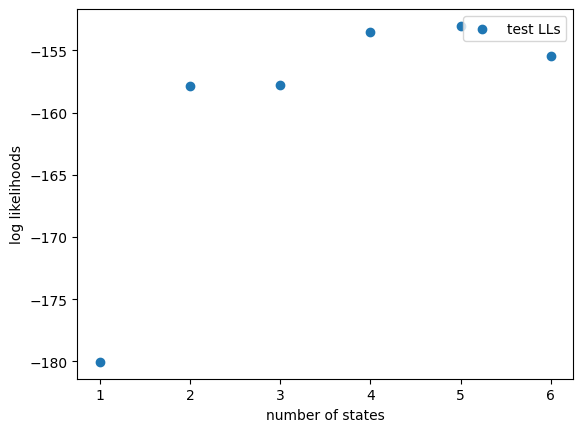

In [535]:
#plt.scatter(num_all_states, mean_lls_train, label="train LLs")
plt.scatter(num_all_states, mean_lls_test, label="test LLs")
plt.xlabel("number of states")
plt.ylabel("log likelihoods")
plt.legend()

In [536]:
best_num_states = 5
glmhmm = ssm.HMM(best_num_states, obs_dim, input_dim, observations="input_driven_obs", 
                observation_kwargs=dict(C=num_categories), transitions="standard")
N_iters = 200 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll = glmhmm.fit(choices_xx, inputs=inpts, method="em", num_iters=N_iters, tolerance=10**-4)

  0%|          | 0/200 [00:00<?, ?it/s]

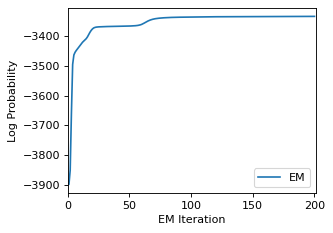

In [539]:
# Plot the log probabilities of the true and fit models. Fit model final LL should be greater 
# than or equal to true LL.
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fit_ll, label="EM")
#plt.plot([0, len(fit_ll)], true_ll * np.ones(2), ':k', label="True")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
plt.xlim(0, len(fit_ll))
plt.ylabel("Log Probability")
plt.show()

In [542]:
# retrieved paramters
from ssm.util import find_permutation
glmhmm.permute(find_permutation(true_latents[0], glmhmm.most_likely_states(true_choices[0], input=inpts[0])))

IndexError: list index out of range

In [ ]:

fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
cols = ['#ff7f00', '#4daf4a', '#377eb8']
recovered_weights = new_glmhmm.observations.params
for k in range(num_states):
    if k ==0:
        plt.plot(range(input_dim), gen_weights[k][0], marker='o',
                 color=cols[k], linestyle='-',
                 lw=1.5, label="generative")
        plt.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = "recovered", linestyle = '--')
    else:
        plt.plot(range(input_dim), gen_weights[k][0], marker='o',
                 color=cols[k], linestyle='-',
                 lw=1.5, label="")
        plt.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = '', linestyle = '--')
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks([0, 1], ['stimulus', 'bias'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("Weight recovery", fontsize=15)

IndexError: index 3 is out of bounds for axis 0 with size 3

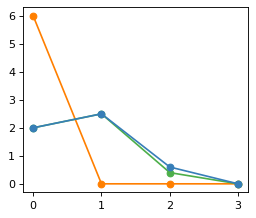

In [558]:
# # Set the parameters of the GLM-HMM
# num_states = 6        # number of discrete states
# obs_dim = 1           # number of observed dimensions
# num_categories = 2    # number of categories for output
# input_dim = 4         # input dimensions
# # Make a GLM-HMM
# true_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs",
#                    observation_kwargs=dict(C=num_categories), transitions="standard")

######################
# gen_weights = np.array([[[6, 0, 0, 0]], [[2,2.5,0.4 ,0]], [[2,2.5,0.6, 0]]])
# gen_log_trans_mat = np.log(np.array([[[0.98, 0.01, 0.01], [0.04, 0.94, 0.02], [0.04, 0.01, 0.96]]]))
# true_glmhmm.observations.params = gen_weights
# true_glmhmm.transitions.params = gen_log_trans_mat
gen_weights = glmhmm.observations.params
gen_log_trans_mat = glmhmm.transitions.params
####################
# Plot generative parameters:
fig = plt.figure(figsize=(8, 3), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
cols = ['#FF7F00', '#4DAF4A', '#377EB8', '#FF7F00', '#4DAF4A', '#377EB8']# TODO
for k in range(num_states):
    plt.plot(range(input_dim), gen_weights[k][0], marker='o',
             color=cols[k], linestyle='-',
             lw=1.5, label="state " + str(k+1))
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks([0, 1,2,3, 4, 5, 6], ['stimulus', 'bias','Prev-choice','Win-stay-lose-switch'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("Generative weights", fontsize = 15)
plt.subplot(1, 2, 2)
gen_trans_mat = np.exp(gen_log_trans_mat)[0]
plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(gen_trans_mat.shape[0]):
    for j in range(gen_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("Generative transition matrix", fontsize = 15)

In [547]:
num_states

6

IndexError: index 3 is out of bounds for axis 0 with size 3

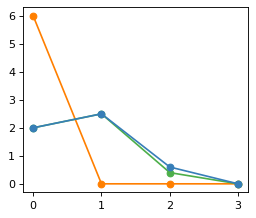

In [549]:

################################################################
# Plot generative parameters:
fig = plt.figure(figsize=(8, 3), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
cols = ['#FF7F00', '#4DAF4A', '#377EB8']
for k in range(num_states):
    plt.plot(range(input_dim), gen_weights[k][0], marker='o',
             color=cols[k], linestyle='-',
             lw=1.5, label="state " + str(k+1))
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks([0, 1,2,3], ['stimulus', 'bias','Prev-choice','Win-stay-lose-switch'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("Generative weights", fontsize = 15)
plt.subplot(1, 2, 2)
gen_trans_mat = np.exp(gen_log_trans_mat)[0]
plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(gen_trans_mat.shape[0]):
    for j in range(gen_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("Generative transition matrix", fontsize = 15)

In [516]:

#recovered_weights = new_glmhmm.observations.params